In [1]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Yolo
from dataset import VOCDataset
from util import (
    non_max_suppression,
    mean_average_precision,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    load_checkpoint,
    get_result,
    input_image
)
from loss import YoloLoss
from PIL import Image
import cv2

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 200
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL_FILE = "overfit.pth.tar"


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes
        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave = True)
    mean_loss = []

    for batchidx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)

        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss = loss.item())
    scheduler.step(sum(mean_loss)/len(mean_loss))
    print(f"mean loss was {sum(mean_loss)/len(mean_loss)}")


In [4]:
model = Yolo(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
train_dataset = VOCDataset(
        "data/train.txt",
        transform=transform,
    )

test_dataset = VOCDataset(
    "data/val.txt", transform=transform,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

for epoch in range(EPOCHS):
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"Train mAP: {mean_avg_prec}")

    train_fn(train_loader, model, optimizer, loss_fn)
    

torch.save(model, 'model.pth')


#test this
losses = []
i = 0
for x, y in test_loader:
    x = x.to(DEVICE)
    for idx in range(16):
        bboxes = cellboxes_to_boxes(model(x))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)


NameError: name 'model' is not defined

tensor([[ 0.5916,  0.6427, -0.0192,  ..., -0.0175, -0.2580,  1.2234]],
       grad_fn=<AddmmBackward0>)
[[0.0, 0.5136762261390686, 0.49629878997802734, 0.5135509967803955, 0.41440027952194214, 0.7871844172477722]]


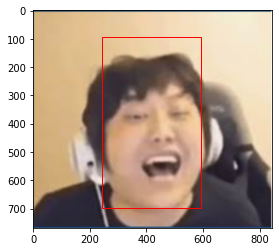

AttributeError: 'numpy.ndarray' object has no attribute 'close'

In [14]:

model = torch.load('model.pth', map_location=torch.device('cpu'))

img = cv2.imread('n1.png')
new_img = input_image(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
print(model(new_img))
bbox = get_result(model(new_img))
print(bbox)
plot_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), bbox)
img.close()

'''
for x, y in test_loader:
    x = x.to(DEVICE)
    print(x)
    print(x.shape)
    bboxes = get_result(model(x))
    print(bboxes)
    plot_image(x[0].permute(1,2,0).to("cpu"), bboxes)
'''
#sample test